In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve

# Helper methods

In [2]:
def save(path):
    plt.savefig('../../images' + path)
    
def loadDataSet():
#     df  = pd.read_csv("../input/stroke-dataset/stroke_subset.csv")
    return pd.read_csv("../input/stroke-dataset/stroke.csv")

In [3]:
df=loadDataSet();
df = df.drop('id',axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 11 columns):
gender               43400 non-null object
age                  43400 non-null float64
hypertension         43400 non-null int64
heart_disease        43400 non-null int64
ever_married         43400 non-null object
work_type            43400 non-null object
Residence_type       43400 non-null object
avg_glucose_level    43400 non-null float64
bmi                  41938 non-null float64
smoking_status       30108 non-null object
stroke               43400 non-null int64
dtypes: float64(3), int64(3), object(5)
memory usage: 3.6+ MB


# Data Exploration

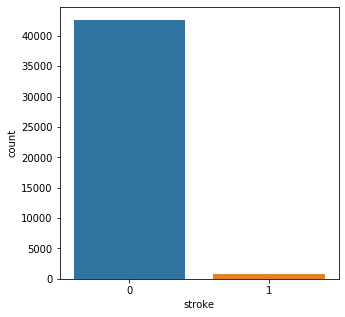

In [4]:
plt.figure(figsize=(5,5))
sns.countplot(x='stroke',data=df)
save('/building_ann/stroke_countplot.png')

In [5]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
43395,Female,10.0,0,0,No,children,Urban,58.64,20.4,never smoked,0
43396,Female,56.0,0,0,Yes,Govt_job,Urban,213.61,55.4,formerly smoked,0
43397,Female,82.0,1,0,Yes,Private,Urban,91.94,28.9,formerly smoked,0
43398,Male,40.0,0,0,Yes,Private,Urban,99.16,33.2,never smoked,0


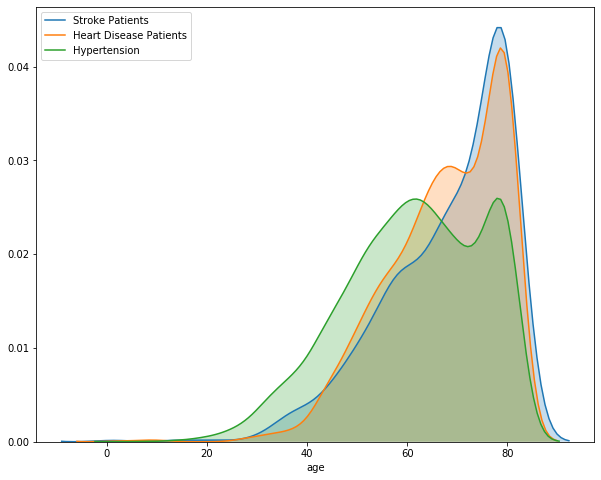

In [6]:
plt.figure(figsize=(10,8))
sns.distplot(df.loc[df['stroke'] == 1]['age'], label='Stroke Patients', kde_kws={"shade": True},hist=False, bins =20)
sns.distplot(df.loc[df['heart_disease'] == 1]['age'], label='Heart Disease Patients', kde_kws={"shade": True},hist=False, bins =20)
sns.distplot(df.loc[df['hypertension'] == 1]['age'], label='Hypertension', kde_kws={"shade": True},hist=False, bins =20)
plt.legend()
save('/building_ann/stroke_age_distplot.png')

In [7]:
df['gender'].value_counts()

Female    25665
Male      17724
Other        11
Name: gender, dtype: int64

In [8]:
df.iloc[95]


gender                          Male
age                               34
hypertension                       0
heart_disease                      1
ever_married                     Yes
work_type                    Private
Residence_type                 Urban
avg_glucose_level             106.23
bmi                              NaN
smoking_status       formerly smoked
stroke                             0
Name: 95, dtype: object

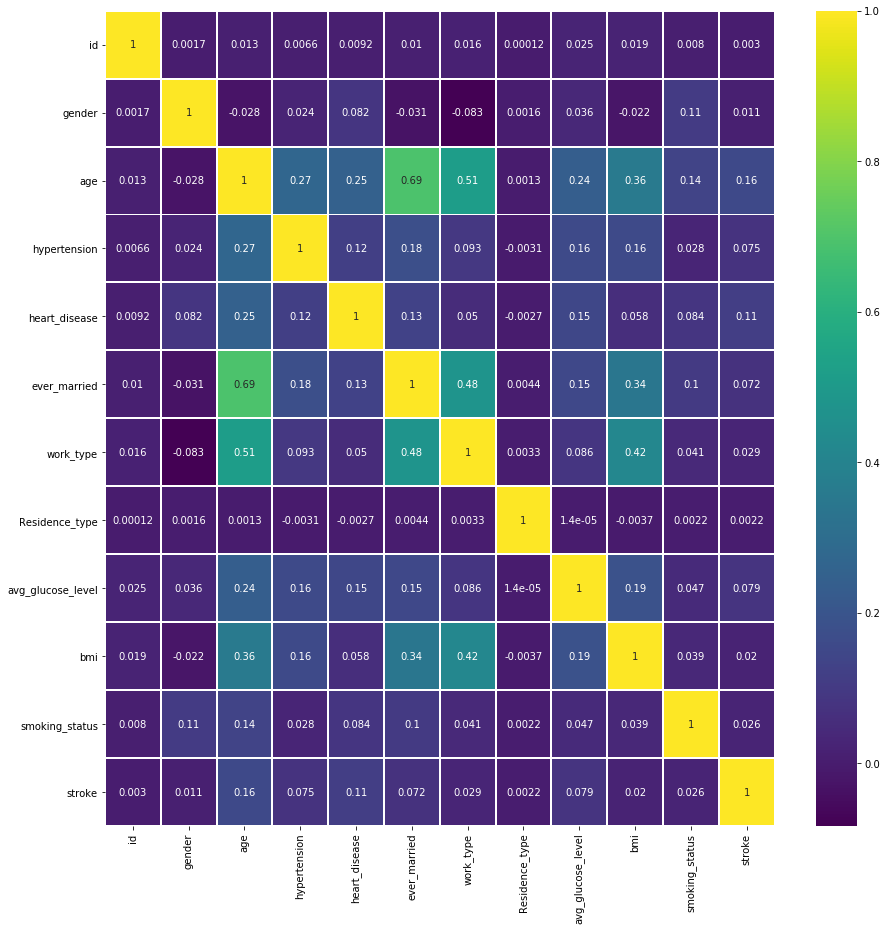

In [9]:
def map_smoking_status(smoking_status):
    if pd.isnull(smoking_status):
        return np.nan
    elif smoking_status=='never smoked':
        return 0
    elif smoking_status=='formerly smoked':
        return 1
    else: 
        return 1
def fill_work_type(work_type):
    if work_type == 'children':
        return 0
    elif work_type == 'Never_worked':
        return 1
    elif work_type == 'Self-employed':
        return 2
    elif work_type == 'Private':
        return 3
    else: 
        return 4
df_hm = loadDataSet()
df_hm['smoking_status'] = df_hm.apply(lambda x : map_smoking_status(x['smoking_status']), axis=1)
df_hm['ever_married'] = df_hm.apply(lambda x : 1 if x['ever_married']=='Yes' else 0, axis =1)
df_hm['Residence_type'] = df_hm.apply(lambda x : 1 if x['Residence_type']=='Urban' else 0, axis =1)
df_hm['work_type'] = df_hm.apply(lambda x : fill_work_type(x['work_type']), axis =1)
df_hm['gender'] = df_hm.apply(lambda x : 1 if x['gender']=='Male' else 0, axis =1)

plt.figure(figsize=(15,15))
sns.heatmap(df_hm.corr(),annot=True,cmap='viridis', linewidth=1)
plt.ylim(12, 0)
save('/building_ann/heatmap.png')

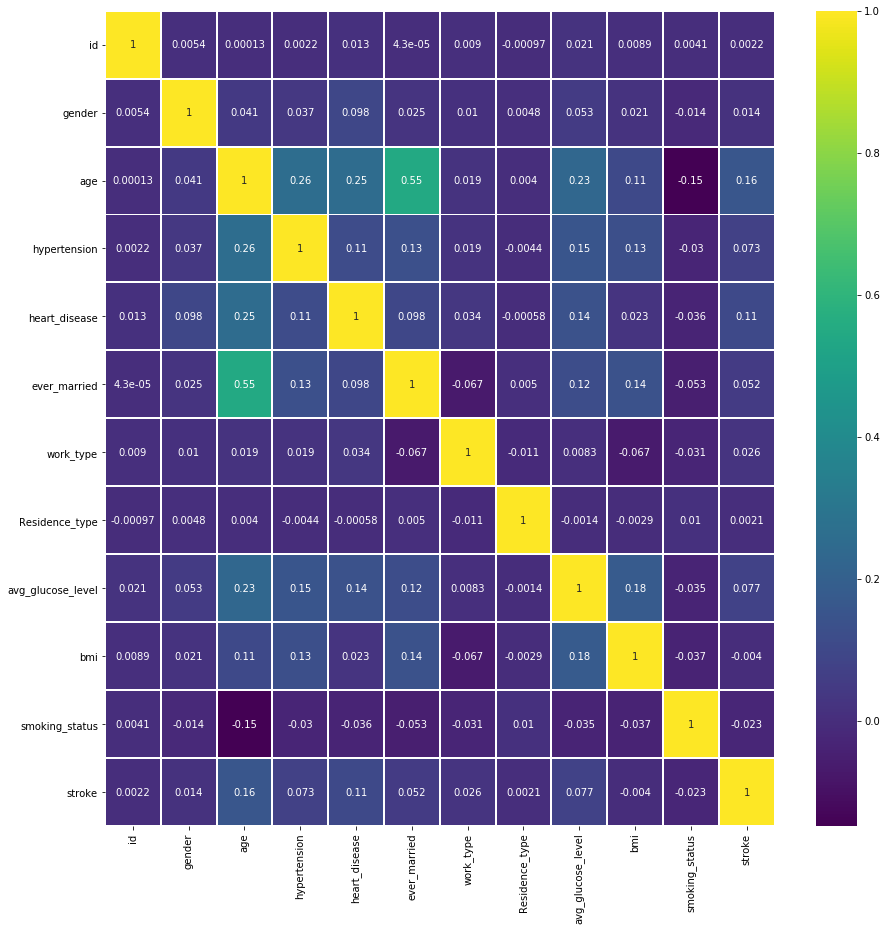

In [10]:
from sklearn import preprocessing
df_hm = loadDataSet()
le = preprocessing.LabelEncoder()
df_hm.gender = le.fit_transform(df_hm.gender)
df_hm.ever_married = le.fit_transform(df_hm.ever_married)
df_hm=df_hm.dropna(subset=['smoking_status'])
df_hm.smoking_status = le.fit_transform(df_hm.smoking_status)
df_hm.Residence_type = le.fit_transform(df_hm.Residence_type)
df_hm.work_type = le.fit_transform(df_hm.work_type)


plt.figure(figsize=(15,15))
sns.heatmap(df_hm.corr(),annot=True,cmap='viridis', linewidth=1)
plt.ylim(12, 0)
save('/building_ann/heatmap.png')

In [11]:
df_hm

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,30468,1,58.0,1,0,1,2,1,87.96,39.2,1,0
3,56543,0,70.0,0,0,1,2,0,69.04,35.9,0,0
6,52800,0,52.0,0,0,1,2,1,77.59,17.7,0,0
7,41413,0,75.0,0,1,1,3,0,243.53,27.0,1,0
8,15266,0,32.0,0,0,1,2,0,77.67,32.3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43395,56196,0,10.0,0,0,0,4,1,58.64,20.4,1,0
43396,5450,0,56.0,0,0,1,0,1,213.61,55.4,0,0
43397,28375,0,82.0,1,0,1,2,1,91.94,28.9,0,0
43398,27973,1,40.0,0,0,1,2,1,99.16,33.2,1,0


C:\Users\dan39\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\dan39\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<Figure size 1800x1800 with 0 Axes>

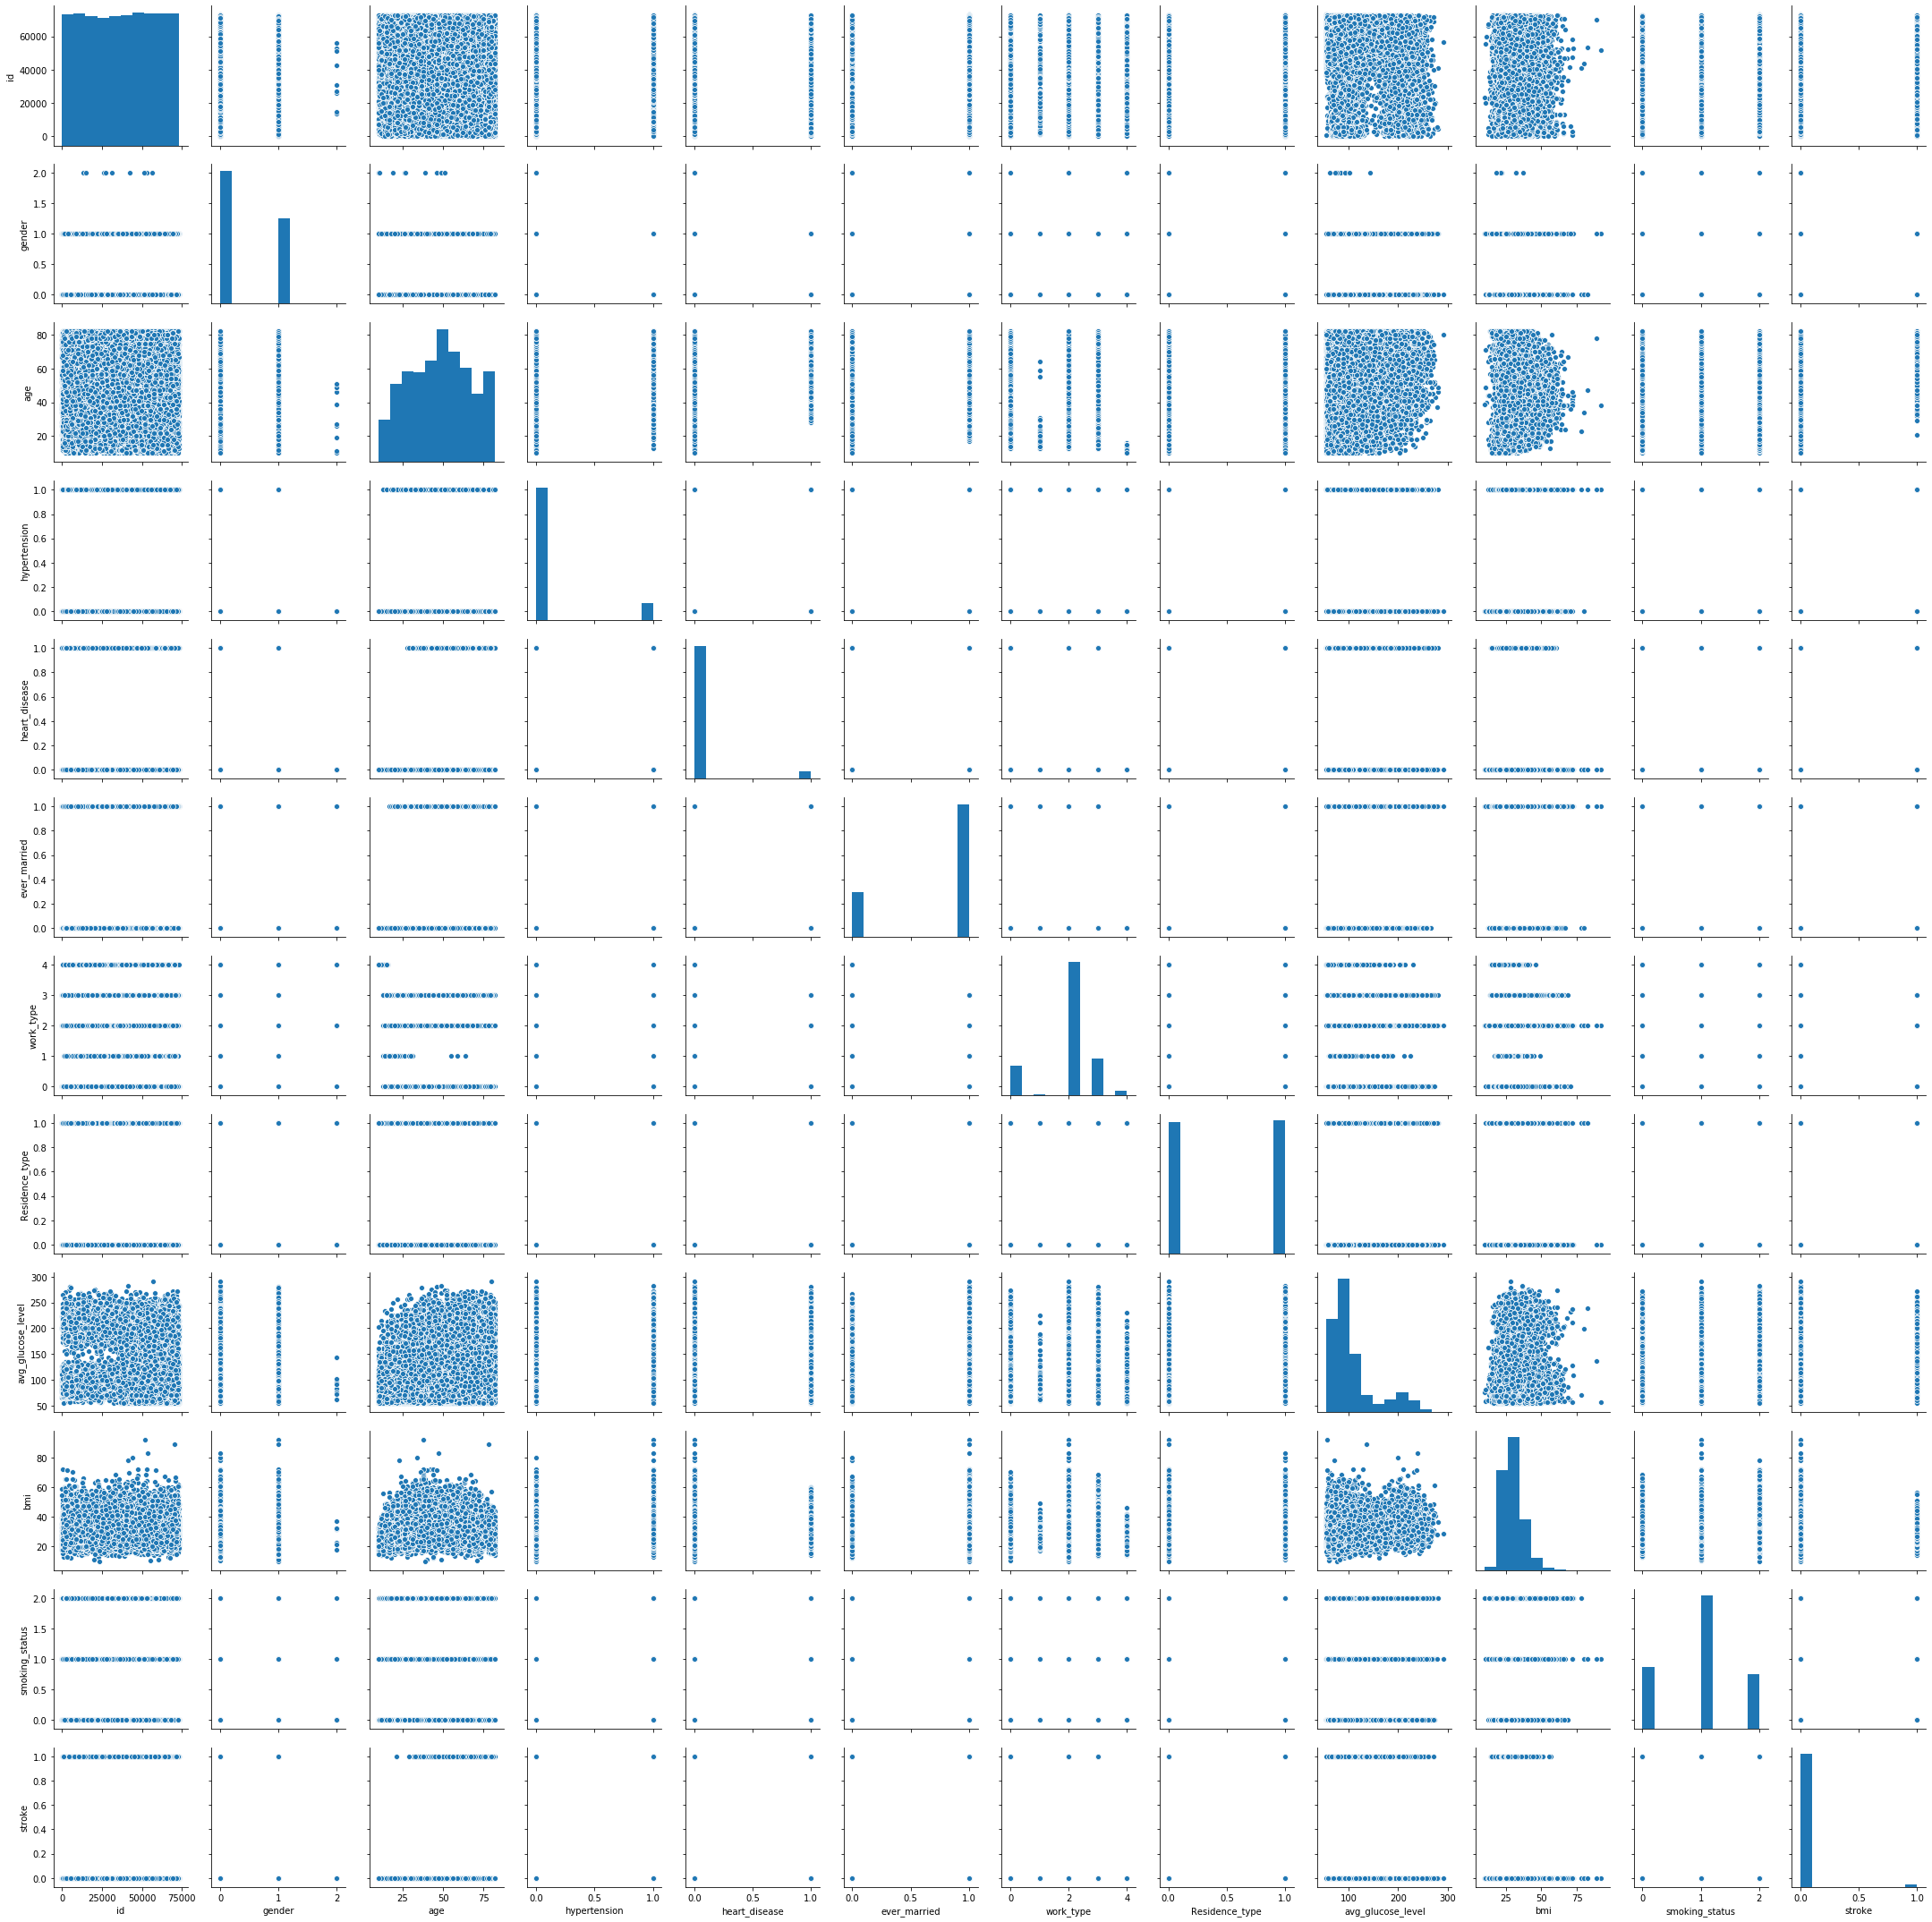

In [12]:
plt.figure(figsize=(25,25))
sns.pairplot(df_hm)
save('/building_ann/pairplot.png')

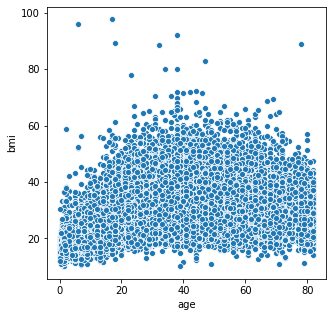

In [13]:
plt.figure(figsize=(5,5))
sns.scatterplot(x='age',y='bmi',data=df)
save('/building_ann/age_bmi_scatterplot.png')

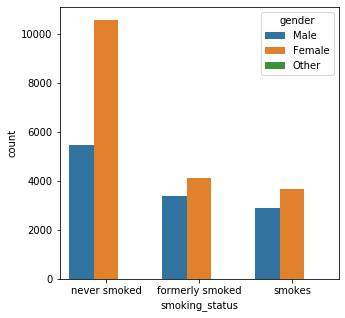

In [14]:
plt.figure(figsize=(5,5))
df = loadDataSet()
sns.countplot(x='smoking_status',data=df,hue='gender')
save('/building_ann/smoking_scatterplot.png')

In [15]:
len(df[df['stroke'] == 1 ])/len(df)

0.01804147465437788

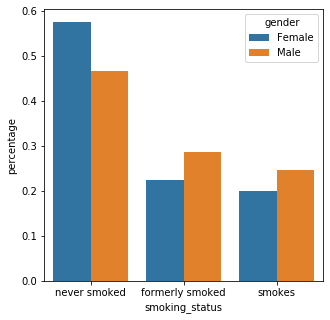

In [16]:
# Adapted code from: https://github.com/mwaskom/seaborn/issues/1027
plt.figure(figsize=(5,5))
df = loadDataSet()
genderOther = df[ df['gender'] == 'Other' ].index
df.drop(genderOther , inplace=True)
x, y, hue = "smoking_status", "percentage", "gender"
# hue_order = ["Male", "Female"]

#f, axes = plt.subplots(1, 2)
# sns.countplot(x=x, hue=hue, data=df, ax=axes[0])
prop_df = (df[x]
           .groupby(df[hue])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

sns.barplot(x=x, y=y, hue=hue, data=prop_df)#, ax=axes[1])
save('/building_ann/gender_smoking_percentage.png')

In [17]:

stroke_y = df[df['stroke'] == 1 ].groupby("smoking_status").count()['stroke']
stroke_n = df[df['stroke'] == 0 ].groupby("smoking_status").count()['stroke']
print(stroke_y/(stroke_y + stroke_n))

smoking_status
formerly smoked    0.029518
never smoked       0.017694
smokes             0.020271
Name: stroke, dtype: float64


In [18]:
df.groupby("smoking_status")['stroke'].value_counts(normalize=True)

smoking_status   stroke
formerly smoked  0         0.970482
                 1         0.029518
never smoked     0         0.982306
                 1         0.017694
smokes           0         0.979729
                 1         0.020271
Name: stroke, dtype: float64

In [19]:
np.bincount(df.apply(lambda x : 1 if x['gender']=='Male' else 0, axis =1))

array([25665, 17724], dtype=int64)

In [20]:
np.bincount(df['stroke'])

array([42606,   783], dtype=int64)

In [21]:
# def fill_smoking_status(smoking_status, isMale):
#     if smoking_status=='never smoked':
#         return 0
#     else: 
#         return isMale if pd.isnull(smoking_status) else 1
# df['smoking_status'] = df.apply(lambda x : fill_smoking_status(x['smoking_status'], x['Male']), axis=1)



# plt.figure(figsize=(9,9))
# sns.heatmap(df.corr(),annot=True,cmap='viridis')
# plt.ylim(9, 0)
# # plt.xlim(0, 1)

# Missing Data

In [22]:
df.isnull().sum()/len(df)

id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  0.033603
smoking_status       0.306299
stroke               0.000000
dtype: float64

In [23]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43395,56196,Female,10.0,0,0,No,children,Urban,58.64,20.4,never smoked,0
43396,5450,Female,56.0,0,0,Yes,Govt_job,Urban,213.61,55.4,formerly smoked,0
43397,28375,Female,82.0,1,0,Yes,Private,Urban,91.94,28.9,formerly smoked,0
43398,27973,Male,40.0,0,0,Yes,Private,Urban,99.16,33.2,never smoked,0


In [24]:
def fill_smoking_status(smoking_status, work_type, gender, age):
    if not pd.isnull(smoking_status):
        return smoking_status
    if work_type=='children' or gender =='Female' or age<18:
        return 'never smoked'
    return 'smokes'

df['smoking_status'] = df.apply(lambda x : fill_smoking_status(x['smoking_status'], x['work_type'], x['gender'], x['age']), axis=1)
smoking_dummies = pd.get_dummies(df['smoking_status'],drop_first=True)
df = pd.concat([df.drop('smoking_status',axis=1),smoking_dummies],axis=1)

df['gender'] = df['gender'].replace(["Other"], "Male")
gender_dummies = pd.get_dummies(df['gender'],drop_first=True)
df = pd.concat([df.drop('gender',axis=1),gender_dummies],axis=1)

bmi_avg= df.groupby('work_type').mean()['bmi']
df['bmi'] = df.apply(lambda x : bmi_avg[x['work_type']] if np.isnan(x['bmi']) else x['bmi'], axis =1)


work_type_dummies = pd.get_dummies(df['work_type'],drop_first=True)
df = pd.concat([df.drop('work_type',axis=1),work_type_dummies],axis=1)

married_dummies = pd.get_dummies(df['ever_married'],drop_first=True)
df = pd.concat([df.drop('ever_married',axis=1),married_dummies],axis=1)
df = df.rename(columns={'Yes': 'Married'})

residence_dummies = pd.get_dummies(df['Residence_type'],drop_first=True)
df = pd.concat([df.drop('Residence_type',axis=1),residence_dummies],axis=1)

df = df.drop('id',axis=1)


df

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,never smoked,smokes,Male,Never_worked,Private,Self-employed,children,Married,Urban
0,3.0,0,0,95.12,18.0,0,1,0,1,0,0,0,1,0,0
1,58.0,1,0,87.96,39.2,0,1,0,1,0,1,0,0,1,1
2,8.0,0,0,110.89,17.6,0,1,0,0,0,1,0,0,0,1
3,70.0,0,0,69.04,35.9,0,0,0,0,0,1,0,0,1,0
4,14.0,0,0,161.28,19.1,0,1,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43395,10.0,0,0,58.64,20.4,0,1,0,0,0,0,0,1,0,1
43396,56.0,0,0,213.61,55.4,0,0,0,0,0,0,0,0,1,1
43397,82.0,1,0,91.94,28.9,0,0,0,0,0,1,0,0,1,1
43398,40.0,0,0,99.16,33.2,0,1,0,1,0,1,0,0,1,1


In [25]:

df.isnull().sum()

age                  0
hypertension         0
heart_disease        0
avg_glucose_level    0
bmi                  0
stroke               0
never smoked         0
smokes               0
Male                 0
Never_worked         0
Private              0
Self-employed        0
children             0
Married              0
Urban                0
dtype: int64

In [26]:
# # sorted(df['smoking_status'].unique())
# plt.figure(figsize=(10,10))
# sns.countplot(x='stroke',data=df,hue='smoking_status')

In [27]:
df.corr()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,never smoked,smokes,Male,Never_worked,Private,Self-employed,children,Married,Urban
age,1.000000,0.272167,0.250191,0.237633,0.359514,0.156050,-0.289649,0.118125,-0.027676,-0.069520,0.143641,0.326911,-0.641238,0.693049,0.001282
hypertension,0.272167,1.000000,0.119761,0.160191,0.158374,0.075322,-0.073508,0.021066,0.024005,-0.019325,0.007247,0.100212,-0.130184,0.176572,-0.003132
heart_disease,0.250191,0.119761,1.000000,0.146925,0.058552,0.113756,-0.111148,0.054988,0.082353,-0.014296,-0.006321,0.099321,-0.089567,0.128832,-0.002748
avg_glucose_level,0.237633,0.160191,0.146925,1.000000,0.188297,0.078908,-0.081802,0.027925,0.035815,-0.014523,0.008039,0.080212,-0.114181,0.153609,0.000030
bmi,0.359514,0.158374,0.058552,0.188297,1.000000,0.022309,-0.176025,0.096751,-0.020762,-0.021919,0.203360,0.084063,-0.462554,0.342796,-0.003646
stroke,0.156050,0.075322,0.113756,0.078908,0.022309,1.000000,-0.043871,0.015827,0.011324,-0.008676,-0.002460,0.061182,-0.054120,0.071917,0.002244
never smoked,-0.289649,-0.073508,-0.111148,-0.081802,-0.176025,-0.043871,1.000000,-0.658614,-0.209859,0.033250,-0.128515,-0.082812,0.309241,-0.242284,-0.000948
smokes,0.118125,0.021066,0.054988,0.027925,0.096751,0.015827,-0.658614,1.000000,0.212991,-0.020450,0.113475,0.022904,-0.212133,0.128714,0.004957
Male,-0.027676,0.024005,0.082353,0.035815,-0.020762,0.011324,-0.209859,0.212991,1.000000,0.002720,-0.052083,-0.002823,0.089122,-0.031073,0.001587
Never_worked,-0.069520,-0.019325,-0.014296,-0.014523,-0.021919,-0.008676,0.033250,-0.020450,0.002720,1.000000,-0.074017,-0.027574,-0.026019,-0.080753,0.003088


## Split Data

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X = df.drop('stroke', axis =1).values
y = df['stroke'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

# Train the Model

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
# part of this code is inspired from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
def plot_model_results(model_name, model):
    fig, (f1, f2) =plt.subplots(1,2, figsize=(10,5))
    predictions = model.predict_classes(X_test)
    print(classification_report(y_test,predictions))
    losses = pd.DataFrame(model.history.history)
    fig1 = losses[['loss','val_loss']].plot(ax=f1) 
    fig1.set_ylabel('Cost')
    fig1.set_xlabel('Epochs')

    cm = confusion_matrix(y_test,predictions > 0.5)
    
    fig2= sns.heatmap(cm, annot=True, fmt="d", ax=f2)
    fig2.set_title('Confusion matrix @{:.2f}'.format(0.5))
    fig2.set_ylabel('Actual label')
    fig2.set_xlabel('Predicted label')
    fig2.set_ylim(2, 0)
#     save('/building_ann/val_loss_' + model_name + '.png')

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
from tensorflow import keras
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


time = datetime.now().strftime("%Y-%m-%d--%H%M")
logdir = 'logs\\hparam_tuning'
# board = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images = True, 
#                     update_freq='epoch', profile_batch=2, embeddings_freq=1)

Using TensorFlow backend.


In [33]:
def create_model(model_name, X_train=X_train, y_train=y_train, with_weigths=True):
    model = Sequential()
    model.add(Dense(30,  activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(15,  activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1,activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=METRICS )
    
    class_weight= {0:1, 1:1}
    if (with_weigths):
        neg, pos = np.bincount(y_train)
        total = neg + pos
        print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
        total, pos, 100 * pos / total))
        weight_for_0 = (1 / neg)*(total)/2.0 
        weight_for_1 = (1 / pos)*(total)/2.0
        class_weight = {0: weight_for_0, 1: weight_for_1}
        print('Weight for class 0: {:.2f}'.format(weight_for_0))
        print('Weight for class 1: {:.2f}'.format(weight_for_1))
        
    model.fit(x=X_train, 
              y=y_train, 
              epochs=500,
              class_weight=class_weight,
              batch_size=2048,
              validation_data=(X_test, y_test), 
              verbose=0,
              callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)]
              )
    
    plot_model_results(model_name,model)

Epoch 00123: early stopping


C:\Users\dan39\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8506
           1       0.00      0.00      0.00       172

    accuracy                           0.98      8678
   macro avg       0.49      0.50      0.49      8678
weighted avg       0.96      0.98      0.97      8678



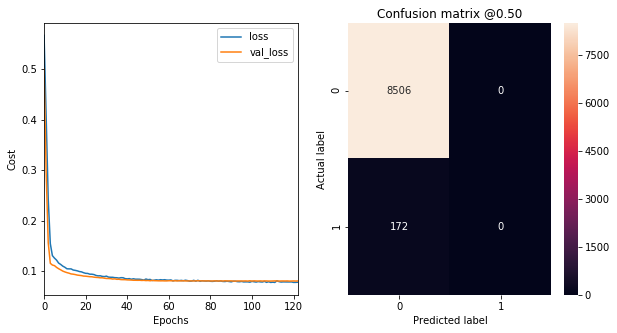

In [34]:
create_model('simple', with_weigths=False)

Examples:
    Total: 34711
    Positive: 611 (1.76% of total)

Weight for class 0: 0.51
Weight for class 1: 28.41
Epoch 00101: early stopping
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      8506
           1       0.06      0.81      0.11       172

    accuracy                           0.74      8678
   macro avg       0.53      0.77      0.48      8678
weighted avg       0.98      0.74      0.83      8678



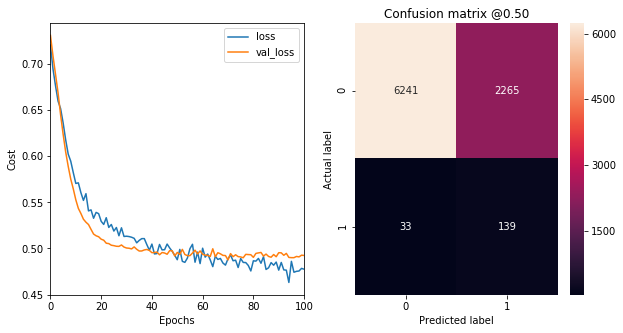

In [35]:
create_model('weighted')

In [ ]:
print(np.bincount(y_train))
smt = SMOTE()
X_train_SMOTE, y_train_SMOTE = smt.fit_sample(X_train, y_train)
print(np.bincount(y_train_SMOTE))
create_model('smote',X_train_SMOTE,y_train_SMOTE)

[34100   611]
[34100 34100]
Examples:
    Total: 68200
    Positive: 34100 (50.00% of total)

Weight for class 0: 1.00
Weight for class 1: 1.00


In [ ]:
print(np.bincount(y_train))
nr = NearMiss()
X_train_miss, y_train_miss = nr.fit_sample(X_train, y_train)
print(np.bincount(y_train_miss))
create_model('near_miss',X_train_miss,y_train_miss)

In [ ]:
print(np.bincount(y_train))
cluster = ClusterCentroids()
X_train_cluster, y_train_cluster = cluster.fit_sample(X_train, y_train)
print(np.bincount(y_train_cluster))
create_model('cluster', X_train_cluster, y_train_cluster)

In [ ]:
print(np.bincount(y_train))
smt = SMOTETomek('auto')
X_train_SMTomek, y_train_SMTomek = smt.fit_sample(X_train, y_train)
print(np.bincount(y_train_SMTomek))
create_model('SMOTETomek', X_train_SMTomek, y_train_SMTomek)

In [ ]:
print(np.bincount(y_train))
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)
print(np.bincount(y_train_rus))
create_model('rus', X_train_rus, y_train_rus)

In [ ]:
print(np.bincount(y_train))
smte = SMOTEENN('auto')
X_train_smte, y_train_smte = smt.fit_sample(X_train, y_train)
print(np.bincount(y_train_smte))
create_model('SMOTETomek', X_train_smte, y_train_smte)

In [ ]:
# from tensorboard.plugins.hparams import api as hp
# HP_NUM_UNITS_L1 = hp.HParam('num_units_l1', hp.Discrete([16, 32]))
# HP_NUM_UNITS_L2 = hp.HParam('num_units_l2', hp.Discrete([8,4]))
# HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
# HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

# METRIC_ACCURACY = 'accuracy'

# with tf.summary.create_file_writer('logs\\hparam_tuning').as_default():
#     hp.hparams_config(
#         hparams=[HP_NUM_UNITS_L1,HP_NUM_UNITS_L2, HP_DROPOUT, HP_OPTIMIZER],
#         metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
#   )

# def train_test_model(hparams):
#     model = Sequential()
#     # input layer
#     model.add(Dense(hparams[HP_NUM_UNITS_L1],  activation='relu'))
#     model.add(Dropout(hparams[HP_DROPOUT]))

#     # hidden layer
#     model.add(Dense(hparams[HP_NUM_UNITS_L2], activation='relu'))
#     model.add(Dropout(hparams[HP_DROPOUT]))
    
#     model.add(Dense(8, activation='relu'))
#     model.add(Dropout(hparams[HP_DROPOUT]))
#     # output layer
#     model.add(Dense(units=1,activation='sigmoid'))

#     # Compile model
#     model.compile(loss='binary_crossentropy', optimizer=hparams[HP_OPTIMIZER],  metrics=['accuracy'])
    
#     model.fit(x=X_train, 
#           y=y_train, 
#           epochs=400,
#           validation_data=(X_test, y_test), 
#           verbose=1,
#           callbacks = [early_stop,
#                        tf.keras.callbacks.TensorBoard(logdir),  # log metrics
#                         hp.KerasCallback(logdir, hparams)]
#           )
    
#     _, accuracy = model.evaluate(X_test, y_test)
    
#     return accuracy

# def run(run_dir, hparams):
#     with tf.summary.create_file_writer(run_dir).as_default():
#         hp.hparams(hparams)  # record the values used in this trial
#         accuracy = train_test_model(hparams)
#         tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

# session_num = 0

# for num_units_l1 in HP_NUM_UNITS_L1.domain.values:
#     for num_units_l2 in HP_NUM_UNITS_L2.domain.values:
#         for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
#             for optimizer in HP_OPTIMIZER.domain.values:
#               hparams = {
#                   HP_NUM_UNITS_L1: num_units_l1,
#                   HP_NUM_UNITS_L2: num_units_l2,
#                   HP_DROPOUT: dropout_rate,
#                   HP_OPTIMIZER: optimizer,
#               }
#               run_name = "run-%d" % session_num
#               print('--- Starting trial: %s' % run_name)
#               print({h.name: hparams[h] for h in hparams})
#               run('logs\\hparam_tuning' + run_name, hparams)
#               session_num += 1

In [ ]:
roc_curve(y_test,predictions)

In [ ]:
len(predictions)

In [ ]:
row = 300
patient = df.drop('stroke', axis = 1).iloc[row]
patient

In [ ]:
patient = scaler.transform(patient.values.reshape(1,13))
patient

In [ ]:
model.predict_classes(patient)[0][0]

In [ ]:
for row in range (0,10):
    patient = df.drop('stroke', axis = 1).iloc[row]
    patient = scaler.transform(patient.values.reshape(1,13))
    prediction = (model.predict_classes(patient))[0][0]
    print ("Predicted:{} Actual:{}".format(prediction,df.iloc[row]['stroke']))